Define Neal's Funnel where $p(x,y) = N(y|0,3) N(x|0,\exp(y/2))$.

In [3]:
from beanmachine.ppl.experimental.tests.vi.neals_funnel import NealsFunnel
nf = NealsFunnel()

Visualize the PDF of Neal's funnel on a grid

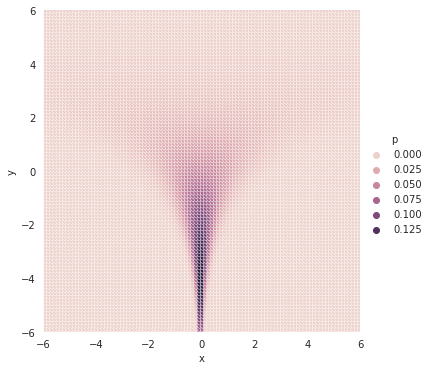

In [4]:
import torch

import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = nf.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Draw some samples from Neal's funnel and plot a KDE

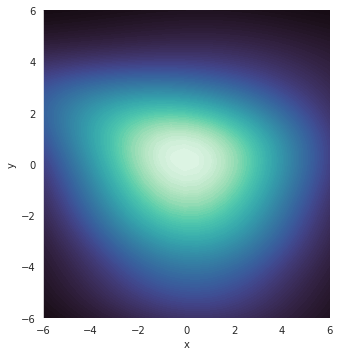

In [5]:
nf_samples = nf.sample(sample_shape=(100,2)).squeeze().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

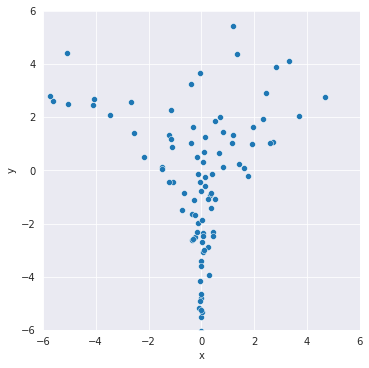

In [6]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Try to perform VI using a neural network transform in a reparameterization trick

In [8]:
from beanmachine.ppl.experimental.vi.VariationalInfer import VariationalApproximation

vi = VariationalApproximation(d=2, target_log_prob=nf.log_prob)
vi.train(epochs=1000)

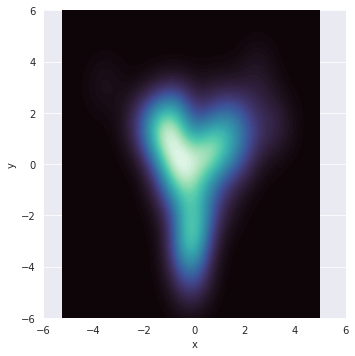

In [9]:
vi_samples = vi.sample((100,2)).detach().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

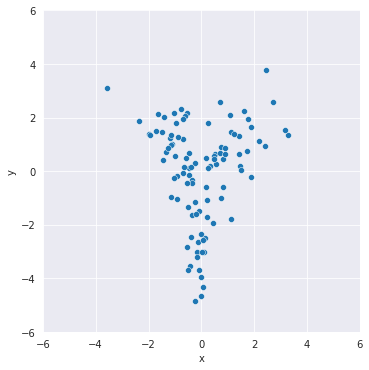

In [10]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

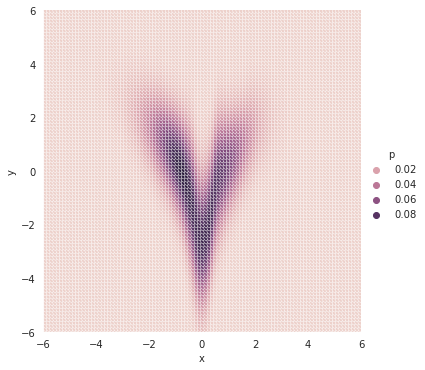

In [11]:
xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

In [12]:
import scipy.stats

scipy.stats.ks_2samp(nf_samples[:,1], vi_samples[:,1]).pvalue

0.05390207893129876

In [13]:
scipy.stats.ks_2samp(nf_samples[:,0], vi_samples[:,0]).pvalue

0.21117008625127576

## Do the same for GMM

In [59]:
import torch.distributions as dist

def gmm(x):
    return torch.log(
        0.5*torch.exp(dist.MultivariateNormal(torch.tensor([-2,-1]), 0.5*torch.eye(2)).log_prob(x)) 
        + 0.5*torch.exp(dist.MultivariateNormal(torch.tensor([1,2]), 0.5*torch.eye(2)).log_prob(x)))

vi = VariationalApproximation(d=2, target_log_prob=gmm)
vi.train(epochs=500, lr=1e-1)

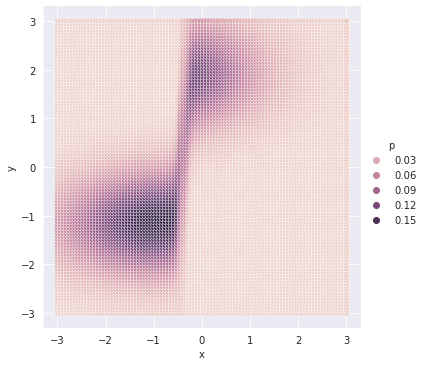

In [61]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

Compare against ground truth

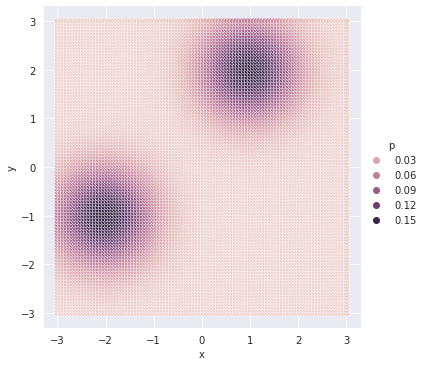

In [62]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = gmm(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

In [ ]:
k